In [1]:
import pandas as pd
#show pandas version
print('Pandas version:',pd.__version__,'\n')

#read in the CSV
dfListens = pd.read_csv('20160313_stats.csv')
#name the columns
dfListens.columns = ['rownum','postnum','IP','method','timestamp']
#look at the 1st and last 10 rows

#add a column with the date from timestamp
dfListens['day'] = pd.to_datetime(dfListens['timestamp'], unit='s').dt.date

#replace postnums with episode names
eps = {776:'Renee',807:'Will',841:'Safia',871:'Shlomo',896:'Sherman',921:'Clare',964:'Erin'}
dfListens['episode'] = dfListens['postnum'].replace(eps)

#show data after transform
print(dfListens.head(n=10),"\n")
print(dfListens.tail(n=10))

Pandas version: 0.18.0 

   rownum  postnum               IP    method   timestamp         day episode
0       2      776    216.12.71.225    player  1450081089  2015-12-14   Renee
1       3      776    216.12.71.225    player  1450101683  2015-12-14   Renee
2       4      776    216.12.71.225  download  1450101715  2015-12-14   Renee
3       5      776    216.12.71.225  download  1450101774  2015-12-14   Renee
4       6      776     24.240.34.21       NaN  1450121645  2015-12-14   Renee
5       7      776  166.137.244.127  download  1450124955  2015-12-14   Renee
6       8      776  166.137.244.127  download  1450124956  2015-12-14   Renee
7       9      776      73.13.30.65  download  1450124978  2015-12-14   Renee
8      10      776    87.165.84.243       NaN  1450128780  2015-12-14   Renee
9      11      776    70.199.218.46       NaN  1450128783  2015-12-14   Renee 

       rownum  postnum               IP method   timestamp         day episode
11485   11487      776   69.116.133.

In [2]:
#group by episode, day, and IP. add column that can be used to count each once
dfIPDay = dfListens.drop(['rownum','method','postnum'], axis=1)
dfIPDay = dfIPDay.groupby(['episode','day','IP']).count()
dfIPDay['countIPDay'] = 1
#using timestamp column to display count here. rename
dfIPDay.columns = ['IPListensThisDay','CountIPVisit']
print(dfIPDay.sort_values(by=['IPListensThisDay'], ascending=False).head(n=20))

#you can see that one IP hit episode 841 1236 times in one day on 1/10 (bot?)

                                   IPListensThisDay  CountIPVisit
episode day        IP                                            
Safia   2016-01-10 172.91.239.120              1236             1
Sherman 2016-02-23 188.182.67.194                25             1
Will    2016-03-04 199.7.159.53                  23             1
Sherman 2016-02-03 108.28.182.162                21             1
Will    2016-01-19 159.153.129.39                20             1
Safia   2016-01-05 71.3.137.51                   20             1
Renee   2015-12-20 163.47.14.103                 19             1
        2016-01-19 159.153.129.39                16             1
Safia   2016-02-17 24.93.25.167                  15             1
Shlomo  2016-02-17 24.93.25.167                  15             1
Clare   2016-02-17 24.93.25.167                  15             1
Will    2016-01-09 81.166.250.64                 15             1
Shlomo  2016-02-21 73.253.101.253                14             1
Sherman 20

In [3]:
print('Listen Counts by Episode:')
print(dfIPDay.groupby(level=['episode']).sum().sort_values(by=['CountIPVisit'], ascending=False))

Listen Counts by Episode:
         IPListensThisDay  CountIPVisit
episode                                
Will                 1710          1035
Renee                1704          1006
Erin                 1460           901
Clare                1345           877
Sherman              1434           845
Shlomo               1378           838
Safia                2464           771


In [4]:
#how many people/services have downloaded each ep?
#print('IP Counts by Episode:')
#print(dfIPDay.groupby(level=['episode','IP']).count().sort_values(by=['listencount'], ascending=False))

In [5]:
#get count of IPs accessing episode per day
dfEpDay = dfIPDay.reset_index()
dfEpDay = dfIPDay.groupby(level=['episode','day']).sum()
dfEpDay = dfEpDay.drop(['IPListensThisDay'],axis=1).sort_values(by=['CountIPVisit'], ascending=False)
print('Top Episode Days:',dfEpDay.head(n=10),'\n')

#get the highest-count day per episode and display
#note: would be "fairer" to get 1st 24 hrs per episode since i don't post at same time of day each time
dfEpDayMax = pd.DataFrame(dfEpDay.groupby(level=['episode']).nth(0)).reset_index()
#add weekday to see if most are Monday/Tuesday when episode published
import datetime as pydt
dfEpDayMax['DayOfWeek'] = pd.to_datetime(dfEpDayMax['day']).apply(lambda x: pydt.datetime.strftime(x, '%A'))
print('Max Listens In a Day by Episode (ordered by date):')
print(dfEpDayMax.sort_values(by=['day']))



Top Episode Days:                     CountIPVisit
episode day                     
Clare   2016-02-15           230
Erin    2016-03-01           206
        2016-02-29           205
Sherman 2016-02-02           194
Shlomo  2016-01-18           108
Clare   2016-02-16            78
Erin    2016-03-02            75
Will    2015-12-21            68
Erin    2016-03-03            62
Sherman 2016-02-03            60 

Max Listens In a Day by Episode (ordered by date):
   episode         day  CountIPVisit  DayOfWeek
6     Will  2015-12-21            68     Monday
3    Safia  2016-01-04            54     Monday
5   Shlomo  2016-01-18           108     Monday
4  Sherman  2016-02-02           194    Tuesday
0    Clare  2016-02-15           230     Monday
1     Erin  2016-03-01           206    Tuesday
2    Renee  2016-03-09            34  Wednesday


          day episode  IPListensThisDay  CountIPVisit
0  2015-12-14   Renee                17            11
1  2015-12-15   Renee                20            14
2  2015-12-16   Renee                32            19
3  2015-12-17   Renee                19            17
4  2015-12-18   Renee                 9             5


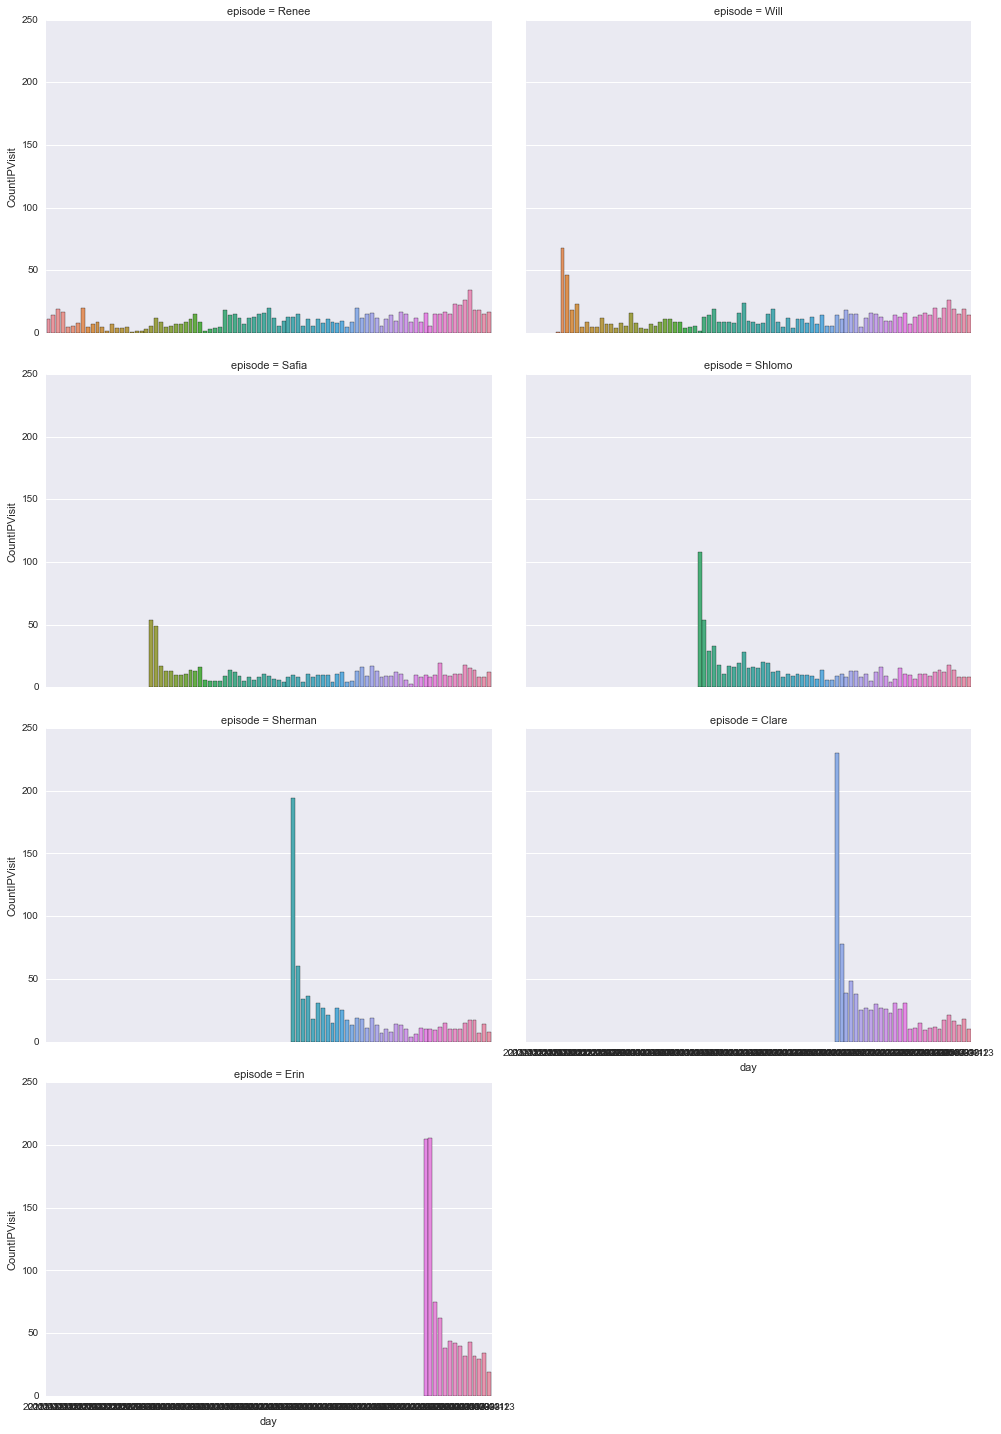

In [6]:
import numpy as np

#go back to simple count per episode per day version
dfEpDay = dfIPDay.groupby(level=['day','episode'], sort=True).sum().reset_index() #dataframe of grouped results
print(dfEpDay.head())



#next: plot listens by day, series per episode?
import seaborn as sns
#show plots in notebook
%matplotlib inline

#sns.pairplot(dfEpDay, x_vars=['episode','day','countipvisit'], y_vars=['episode','day','countipvisit'])
#sns.plt.show()

g = sns.factorplot(data=dfEpDay, x="day", y="CountIPVisit", col="episode", kind="bar", size=5, aspect=1.4, col_wrap=2)